In [2]:
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything
import numpy as np
import torch
from DLIP.utils.metrics.inst_seg_metrics import get_fast_aji_plus, remap_label
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything
import numpy as np
import torch
import wandb
import pandas as pd 
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_trainer import load_trainer
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.parse_arguments import parse_arguments
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure
from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer


logging.basicConfig(level=logging.INFO)
logging.info("Initalizing model")

config_files = '/home/ws/kg2371/projects/sem-segmentation/DLIP/experiments/configurations/bmt_unet.yaml'
result_dir = './'


cfg_yaml = merge_configs(config_files)
base_path=os.path.expandvars(result_dir)
experiment_name=cfg_yaml['experiment.name']['value']

cfg_yaml['wandb.mode']['value'] = 'disabled'

experiment_dir, config_name = prepare_directory_structure(
    base_path=base_path,
    experiment_name=experiment_name,
    data_module_name=cfg_yaml['data.datamodule.name']['value'],
    model_name=cfg_yaml['model.name']['value']
)

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=experiment_dir,
    config_name=config_name
)

config.update({'data.datamodule.arguments.root_dir':f"{config['prefix']}/{config['root_dir_base']}"},allow_val_change=True) 

seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])

from DLIP.utils.post_processing.distmap2inst import DistMapPostProcessor

post_pro = DistMapPostProcessor(
    sigma_cell=1.0,
    th_cell=0.03,
    th_seed=0.6,
    do_splitting=False,
    do_area_based_filtering=False,
    do_fill_holes=False,
    valid_area_median_factors=[0.25,3]
)

data = load_data_module(parameters_splitted["data"])
model = load_model(parameters_splitted["model"],checkpoint_path_str='/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/UnetInstance/0171/dnn_weights.ckpt')

/home/ws/kg2371/anaconda3/envs/sem-segmentation/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO:root:Initalizing model
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Global seed set to 1337
INFO:root:Using 0 workers for data loading
INFO:root:Length of validation dataset: 25
INFO:root:Length of test dataset: 28


In [8]:
for batch in data.test_dataloader():
    x,y_dist,y_class = batch
    break
y_pred = model(x)
x = x.numpy()
y_class = y_class.numpy()
y_pred_post = []
for y_pred_i in y_pred:
    y_pred_post.append(post_pro.process(y_pred_i[0].detach().cpu().numpy(),None))

In [10]:
bin = 5
import cv2
for i in range(16):
    y_true_masks = np.stack([x for x in y_class[i] if np.sum(x) > 0])
    y_true_masks = sorted(y_true_masks,key=lambda x: np.sum(x))
    y_true_masks_summed = np.zeros_like(y_class[i][0])*0.
    for j in range(len(y_true_masks)):
        y_true_masks_summed[y_true_masks[j] > 0] = j+1
    y_true = y_true_masks_summed
    cv2.imwrite(f'/home/ws/kg2371/projects/sem-segmentation/plots/UNet/bin_{bin}/y_true/{i}.png',y_true*(255/np.max(y_true)))
    cv2.imwrite(f'/home/ws/kg2371/projects/sem-segmentation/plots/UNet/bin_{bin}/y_pred/{i}.png',y_pred_post[i]*(255/np.max(y_pred_post[i])))
    cv2.imwrite(f'/home/ws/kg2371/projects/sem-segmentation/plots/UNet/bin_{bin}/x/{i}.png',x[i][0]*255)

In [11]:
from pathlib import Path
for i in range(6):
    Path(f"/home/ws/kg2371/projects/sem-segmentation/plots/Mask/bin_{i}/y_pred").mkdir(parents=True, exist_ok=True)
    Path(f"/home/ws/kg2371/projects/sem-segmentation/plots/Mask/bin_{i}/y_true").mkdir(parents=True, exist_ok=True)
    Path(f"/home/ws/kg2371/projects/sem-segmentation/plots/Mask/bin_{i}/x").mkdir(parents=True, exist_ok=True)

In [5]:
from tqdm import tqdm

api = wandb.Api()
runs = api.sweep("lucare/bmt_unet_vs_maskedrcnn/4g3qp5dp").runs


cluster_lst_seed = get_cfg_clusters(runs, ["experiment.seed"])

all_ajis = {}
for cluster in tqdm(cluster_lst_seed):
    print(runs[cluster[0]].config['root_dir_base'])
    ajis_cluster = []
    for run_id in cluster:
        run_i = runs[run_id]
        weights_path = f'/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/UnetInstance/{run_i.name.split("_")[-1]}/dnn_weights.ckpt'
        model = load_model(parameters_splitted["model"],checkpoint_path_str=weights_path)
        model.eval()
        ajis = []
        for key in tqdm(sorted(metrics.keys())):
            x = tifffile.imread(f'/home/ws/kg2371/datasets/isbi14_challenge/all_test/samples/{metrics[key]}')
            y_true = tifffile.imread(f'/home/ws/kg2371/datasets/isbi14_challenge/all_test/labels/{metrics[key]}')
            y_true_masks = np.stack([x for x in y_true if np.sum(x) > 0])
            y_true_masks = sorted(y_true_masks,key=lambda x: np.sum(x))
            y_true_masks_summed = np.zeros_like(y_true[0])*0.
            for j in range(len(y_true_masks)):
                y_true_masks_summed[y_true_masks[j] > 0] = j+1
            y_true = y_true_masks_summed
            y_pred = model(torch.tensor(x).unsqueeze(0).unsqueeze(0) / 255.)[0,0].detach().cpu().numpy()
            y_pred = post_pro.process(y_pred,None)
            aji = get_fast_aji_plus(remap_label(y_true),remap_label(y_pred))
            ajis.append(aji)
        ajis_cluster.append(ajis)
    all_ajis[runs[cluster[0]].config['root_dir_base']] = ajis_cluster

NameError: name 'get_cfg_clusters' is not defined

In [1]:
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything
import numpy as np
import torch
from DLIP.utils.metrics.inst_seg_metrics import get_fast_aji_plus, remap_label
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything
import numpy as np
import torch
import wandb
import pandas as pd 
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_trainer import load_trainer
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.parse_arguments import parse_arguments
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure
from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer


config_files = '/home/ws/kg2371/projects/sem-segmentation/DLIP/experiments/configurations/bmt_maskedrcnn.yaml'
result_dir = './'

cfg_yaml = merge_configs(config_files)
base_path=os.path.expandvars(result_dir)
experiment_name=cfg_yaml['experiment.name']['value']

cfg_yaml['wandb.mode']['value'] = 'disabled'

experiment_dir, config_name = prepare_directory_structure(
    base_path=base_path,
    experiment_name=experiment_name,
    data_module_name=cfg_yaml['data.datamodule.name']['value'],
    model_name=cfg_yaml['model.name']['value']
)

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=experiment_dir,
    config_name=config_name
)

config.update({'data.datamodule.arguments.root_dir':f"{config['prefix']}/{config['root_dir_base']}"},allow_val_change=True) 

seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])


MIN_MASK_SIZE_THESHOLD = 10

OVERLAPPING_THRESHOLD = 0.41
MIN_ACTIVATION = 0.53
# conf: lower_threshold = THRESHOLD_CONF, high_threshold = 1.0
THRESHOLD_CONF = 0.8
# not_conf: lower_threshold = THRESHOLD_NOT_CONF, high_threshold = THRESHOLD_CONF
THRESHOLD_NOT_CONF = 0.55

def post_process_masked_rcnn(pred,lower_threshold,high_threshold,H,W):
    scores = pred['scores']
    masks = pred['masks']   
    masks = masks[(scores > lower_threshold) & (scores <= high_threshold)]
    scores = scores[(scores > lower_threshold) & (scores <= high_threshold)]
    masks_summed = torch.zeros((H,W))
    if len(masks) == 0:
        return masks_summed
    final_mask = torch.stack(sorted(masks,key=lambda x: torch.sum(x>MIN_ACTIVATION)))
    for j in range(len(final_mask)):
        masks_summed[(final_mask[j]> MIN_ACTIVATION).squeeze()] = j+1
    return masks_summed.to(torch.uint8)


data = load_data_module(parameters_splitted["data"])
model = load_model(parameters_splitted["model"],checkpoint_path_str='/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/MaskedRCNN/0175/dnn_weights.ckpt')
model = model.eval()

/home/ws/kg2371/anaconda3/envs/sem-segmentation/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Global seed set to 1337


In [2]:
for batch in data.test_dataloader():
    x,y_class = batch
    break
y_pred = model(x)
x = x.numpy()
y_class = y_class.numpy()
y_pred_post = []
for y_pred_i in y_pred:
    y_pred_post.append(post_process_masked_rcnn(y_pred_i,THRESHOLD_CONF,1.0,512,512).detach().cpu().numpy())

In [ ]:
bin = 5
import cv2
for i in range(16):
    y_true_masks = np.stack([x for x in y_class[i] if np.sum(x) > 0])
    y_true_masks = sorted(y_true_masks,key=lambda x: np.sum(x))
    y_true_masks_summed = np.zeros_like(y_class[i][0])*0.
    for j in range(len(y_true_masks)):
        y_true_masks_summed[y_true_masks[j] > 0] = j+1
    y_true = y_true_masks_summed
    cv2.imwrite(f'/home/ws/kg2371/projects/sem-segmentation/plots/Mask/bin_{bin}/y_true/{i}.png',y_true*(255/np.max(y_true)))
    cv2.imwrite(f'/home/ws/kg2371/projects/sem-segmentation/plots/Mask/bin_{bin}/y_pred/{i}.png',y_pred_post[i]*(255/np.max(y_pred_post[i])))
    cv2.imwrite(f'/home/ws/kg2371/projects/sem-segmentation/plots/Mask/bin_{bin}/x/{i}.png',x[i][0]*255)

In [ ]:
from tqdm import tqdm

api = wandb.Api()
runs = api.sweep("lucare/bmt_unet_vs_maskedrcnn/1me7ydtt").runs

cluster_lst_seed = get_cfg_clusters(runs, ["experiment.seed"])

all_ajis_masked = {}
for cluster in (cluster_lst_seed):
    print(runs[cluster[0]].config['root_dir_base'])
    ajis_cluster_maskedrcnn = []
    for run_id in cluster:
        run_i = runs[run_id]
        weights_path = f'/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/MaskedRCNN/{run_i.name.split("_")[-1]}/dnn_weights.ckpt'
        model = load_model(parameters_splitted["model"],checkpoint_path_str=weights_path)
        model.eval()
        ajis = []
        for key in tqdm(sorted(metrics.keys())):
            x = tifffile.imread(f'/home/ws/kg2371/datasets/isbi14_challenge/all_test/samples/{metrics[key]}')
            y_true = tifffile.imread(f'/home/ws/kg2371/datasets/isbi14_challenge/all_test/labels/{metrics[key]}')
            y_true_masks = np.stack([x for x in y_true if np.sum(x) > 0])
            y_true_masks = sorted(y_true_masks,key=lambda x: np.sum(x))
            y_true_masks_summed = np.zeros_like(y_true[0])*0.
            for j in range(len(y_true_masks)):
                y_true_masks_summed[y_true_masks[j] > 0] = j+1
            y_true = y_true_masks_summed
            y_pred = model(torch.tensor(x).unsqueeze(0).unsqueeze(0) / 255.)[0]
            y_pred = post_process_masked_rcnn(y_pred,THRESHOLD_CONF,1.0,512,512).detach().cpu().numpy()
            aji = get_fast_aji_plus(remap_label(y_true),remap_label(y_pred))
            ajis.append(aji)
        ajis_cluster_maskedrcnn.append(ajis)
    all_ajis_masked[runs[cluster[0]].config['root_dir_base']] = ajis_cluster_maskedrcnn

bin_5


100%|██████████| 165/165 [01:17<00:00,  2.12it/s]

bin_4
bin_3
bin_2
bin_1
bin_0


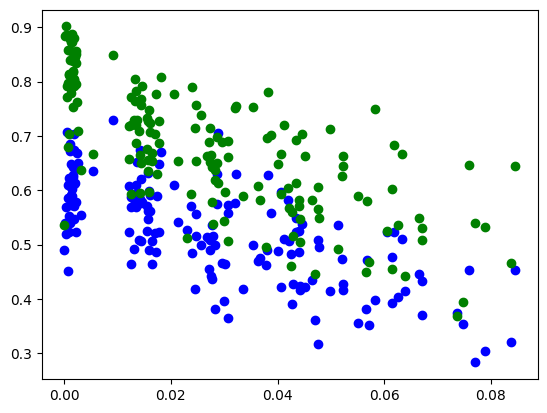

In [ ]:
plt.scatter(x=np.array(sorted(metrics.keys())),y=np.mean(all_ajis['bin_5'],axis=0),c='blue')
plt.scatter(x=np.array(sorted(metrics.keys())),y=np.mean(all_ajis_masked['bin_5'],axis=0),c='green')

In [ ]:
import pickle

# with open('all_ajis.pickle', 'wb') as handle:
#     pickle.dump(all_ajis, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_ajis.pickle', 'rb') as handle:
    all_ajis = pickle.load(handle)
    
# with open('all_ajis_masked.pickle', 'wb') as handle:
#     pickle.dump(all_ajis_masked, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_ajis_masked.pickle', 'rb') as handle:
    all_ajis_masked = pickle.load(handle)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



for bin in [0,1,2,3,4,5]:
        # You typically want your plot to be ~1.33x wider than tall.
    # Common sizes: (10, 7.5) and (12, 9)
    plt.figure(figsize=(10,10))

    # Remove the plot frame lines. They are unnecessary chartjunk.
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Ensure that the axis ticks only show up on the bottom and left of the plot.
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    plt.yticks(fontsize=12)  
    plt.xticks(fontsize=12)

    # Along the same vein, make sure your axis labels are large
    # enough to be easily read as well. Make them slightly larger
    # than your axis tick labels so they stand out.
    plt.xlabel("Θ",fontsize=12)
    plt.ylabel("AJI+",fontsize=12)
    plt.title(f'S_{bin}')
    plt.scatter(x=np.array(sorted(metrics.keys())),y=np.mean(all_ajis[f'bin_{bin}'],axis=0),c='blue',s=10,alpha=0.4)
    x=np.array(sorted(metrics.keys()))
    y=np.mean(all_ajis[f'bin_{bin}'],axis=0)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),c='blue')
    plt.scatter(x=np.array(sorted(metrics.keys())),y=np.mean(all_ajis_masked[f'bin_{bin}'],axis=0),c='green',s=10,alpha=0.4)
    x=np.array(sorted(metrics.keys()))
    y=np.mean(all_ajis_masked[f'bin_{bin}'],axis=0)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),c='green')
    print(f'Unet: {np.mean(np.mean(all_ajis[f"bin_{bin}"],axis=0))}, Masked: {np.mean(np.mean(all_ajis_masked[f"bin_{bin}"],axis=0))}')
    plt.legend(frameon=False)
    #plt.show()
    plt.savefig(f'{bin}.svg')
    plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Unet: 0.5985577685041638, Masked: 0.639932614025125
Unet: 0.701830292630549, Masked: 0.7200955408670975
Unet: 0.7078148634783697, Masked: 0.7334650387776833
Unet: 0.6592129659954473, Masked: 0.7437065410217638


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Unet: 0.6273112055342067, Masked: 0.7062144724115753
Unet: 0.5268047203169868, Masked: 0.6815121036407711
